In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [1]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.2. Data Processing/Output'
cur_date = '022426'

library(missForest)
library(readxl)
library(openxlsx)
library(tidyverse)
library(factoextra)
#library(ggh4x)

# reading in files
ws_df = data.frame(Sample = 'WS', read_excel("Input/Woodsmoke_Data_012226.xlsx", sheet = 2)) %>%
    select(-Number)
wf_df = data.frame(Sample = 'WF', read_excel("Input/Wildfire_Data_012226.xlsx", sheet = 2)) %>%
    select(-Number)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
head(ws_df)
head(wf_df)

,Sample,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WS,429174,Arif et al. 2017,1,429174_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
2,WS,429174,Arif et al. 2017,2,429174_2,PAH,Weight,DTXSID3023845,Acenaphthylene,13.42
3,WS,298566,Jalava et al. 2010,1,298566_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
4,WS,298566,Jalava et al. 2010,2,298566_2,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
5,WS,298566,Jalava et al. 2010,3,298566_3,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
6,WS,298566,Jalava et al. 2010,4,298566_4,PAH,Weight,DTXSID3023845,Acenaphthylene,NA


,Sample,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WF,1289737,Campbell et al. 2024,1,1289737_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
2,WF,1289739,Campos et al. 2019,1,1289739_1,PAH,Weight,DTXSID3023845,Acenaphthylene,3.5200000000000002E-2
3,WF,1289739,Campos et al. 2019,2,1289739_2,PAH,Weight,DTXSID3023845,Acenaphthylene,1.21E-2
4,WF,1289739,Campos et al. 2019,3,1289739_3,PAH,Weight,DTXSID3023845,Acenaphthylene,8.8000000000000005E-3
5,WF,1289739,Campos et al. 2019,4,1289739_4,PAH,Weight,DTXSID3023845,Acenaphthylene,1.12E-2
6,WF,1289739,Campos et al. 2019,5,1289739_5,PAH,Weight,DTXSID3023845,Acenaphthylene,4.5199999999999997E-2


In [3]:
dim(ws_df)
dim(wf_df)

[1] 1407   10

[1] 2423   10

Starting with 4391 WS records and 3795 WF records. 

In [4]:
# combining dfs
combined_df = rbind(ws_df, wf_df)
           
head(combined_df)

,Sample,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,Metric,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WS,429174,Arif et al. 2017,1,429174_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
2,WS,429174,Arif et al. 2017,2,429174_2,PAH,Weight,DTXSID3023845,Acenaphthylene,13.42
3,WS,298566,Jalava et al. 2010,1,298566_1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
4,WS,298566,Jalava et al. 2010,2,298566_2,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
5,WS,298566,Jalava et al. 2010,3,298566_3,PAH,Weight,DTXSID3023845,Acenaphthylene,NA
6,WS,298566,Jalava et al. 2010,4,298566_4,PAH,Weight,DTXSID3023845,Acenaphthylene,NA


In [5]:
length(unique(combined_df$Name))
length(unique(ws_df$Name))
length(unique(wf_df$Name))

[1] 33

[1] 32

[1] 32

114 unique metals/chemicals total.

# Filter #1: Chemical/Metal Background Filters

Determining what variables have missing data for all variables delineated based on the dfs the data will be split into and analyzed. 

A variable (ie. `Name` which represents a chemical or metal) will be retained if >= 25% of its experimental data points were measurable values. In other words, chemicals or metals were excluded if they had NAs (not evaluated) or had non-detect values across < 75% of the samples.

In [6]:
`%notin%` <- Negate(`%in%`)

sample_type_presence_df = combined_df %>%
    # if an experimental value is there count it as being "present"
    mutate(count = ifelse(Value %notin% c('NA', 'ND'), 1, 0)) %>%
    # determining which have at least 25% experimental values for each chemical/metal
    group_by(Metric, Sample, Name) %>%
    # calculating the percentage of experimental data points
    reframe(Variable_Presence_Percentage = (sum(count)/n()) * 100) %>%
    filter(Variable_Presence_Percentage >= 25) 

head(sample_type_presence_df)

Metric,Sample,Name,Variable_Presence_Percentage
<chr>,<chr>,<chr>,<dbl>
Volume,WF,Acenaphthylene,27.02703
Volume,WF,Anthracene,40.54054
Volume,WF,Benz(a)anthracene,62.16216
Volume,WF,Benzene,100.00000
Volume,WF,Benzo(GHI)perylene,56.75676
Volume,WF,Benzo(a)pyrene,48.64865


In [7]:
# filtering the original df
filter1_df = inner_join(sample_type_presence_df[,1:3], combined_df) 

head(filter1_df)

Joining with `by = join_by(Metric, Sample, Name)`


Metric,Sample,Name,HAWC_ID,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Volume,WF,Acenaphthylene,1289895,Silberstein et al. 2023,1,1289895_1,PAH,DTXSID3023845,7.0000000000000007E-2
Volume,WF,Acenaphthylene,1286055,Simms et al. 2021,1,1286055_1,PAH,DTXSID3023845,NA
Volume,WF,Acenaphthylene,1285830,Navarro et al. 2019,1,1285830_1,PAH,DTXSID3023845,1
Volume,WF,Acenaphthylene,1285830,Navarro et al. 2019,2,1285830_2,PAH,DTXSID3023845,1
Volume,WF,Acenaphthylene,1285830,Navarro et al. 2019,3,1285830_3,PAH,DTXSID3023845,1
Volume,WF,Acenaphthylene,1289909,Trieu et al. 2024,1,1289909_1,PAH,DTXSID3023845,3.8999999999999998E-3


In [8]:
dim(combined_df)
dim(filter1_df)

combined_df %>%
    group_by(Metric) %>%
    count()
filter1_df %>%
    group_by(Metric) %>%
    count()

[1] 3830   10

[1] 3756   10

Metric,n
<chr>,<int>
Volume,1340
Weight,2490


Metric,n
<chr>,<int>
Volume,1266
Weight,2490


Started with 3830 records, 74 were removed, leaving 3756. 

# Filter #2: Study Background Filter

A study will be retained if >= 25% of its experimental data points were measurable values. In other words, chemicals were excluded if they were NAs (not evaluated) or had non-detect values across < 75% of the samples.

In [9]:
study_type_presence_df = filter1_df %>%
    # if an experimental value is there count it as being "present"
    mutate(count = ifelse(Value %notin% c('NA', 'ND'), 1, 0)) %>%
    # determining which have at least 20% experimental values for each chemical/metal
    group_by(Metric, Class, HAWC_ID) %>%
    # calculating the percentage of experimental data points
    reframe(Study_Presence_Percentage = (sum(count)/n()) * 100) %>%
    filter(Study_Presence_Percentage >= 25) 

head(study_type_presence_df)

Metric,Class,HAWC_ID,Study_Presence_Percentage
<chr>,<chr>,<chr>,<dbl>
Volume,Metal,1070627,88.88889
Volume,Metal,1263480,85.18519
Volume,Metal,1263484,66.66667
Volume,Metal,1289778,55.55556
Volume,Metal,1289808,100.00000
Volume,Metal,1289847,88.88889


In [10]:
filter2_df = inner_join(study_type_presence_df[,1:3], filter1_df)

head(filter2_df)

Joining with `by = join_by(Metric, Class, HAWC_ID)`


Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
Volume,Metal,1070627,WF,Calcium,Siregar et al. 2022,1,1070627_1,Ca,1370.1
Volume,Metal,1070627,WF,Calcium,Siregar et al. 2022,2,1070627_2,Ca,595.20000000000005
Volume,Metal,1070627,WF,Copper,Siregar et al. 2022,1,1070627_1,Cu,127
Volume,Metal,1070627,WF,Copper,Siregar et al. 2022,2,1070627_2,Cu,20.3
Volume,Metal,1070627,WF,Iron,Siregar et al. 2022,1,1070627_1,Fe,1115
Volume,Metal,1070627,WF,Iron,Siregar et al. 2022,2,1070627_2,Fe,427


In [11]:
dim(filter1_df)
dim(filter2_df)

[1] 3756   10

[1] 3535   10

221 more records were removed.

# Filter #3: Chemical/Metal Background Filter

In the intial filter, WS and WF samples were combined. However, this time variables (ie. metal or chemical) will be split based on their `Metric` (ie. volume or weight) and then retained if that variable is found in both woodsmoke and wildfire samples within volume or weight samples.

In [12]:
split_filtered_df = filter2_df %>%
    group_by(Sample, Metric) %>%
    group_split

split_ws_vol_df = split_filtered_df[[3]]
split_ws_weight_df = split_filtered_df[[4]]
split_wf_vol_df = split_filtered_df[[1]]
split_wf_weight_df = split_filtered_df[[2]]

In [13]:
# seeing how many unique variables are in each df and if they're consistent in each file
length(unique(split_ws_vol_df$Name))
length(unique(split_wf_vol_df$Name))
length(unique(split_ws_weight_df$Name))
length(unique(split_wf_weight_df$Name))

[1] 28

[1] 26

[1] 27

[1] 27

In [14]:
# they're not so first getting variables that are in weight or volume samples
consistent_wf_vol_df = split_wf_vol_df %>%
    filter(Name %in% unique(split_ws_vol_df$Name))
consistent_ws_vol_df = split_ws_vol_df %>%
    filter(Name %in% consistent_wf_vol_df$Name)
consistent_wf_weight_df = split_wf_weight_df %>%
    filter(Name %in% unique(split_ws_weight_df$Name))
consistent_ws_weight_df = split_ws_weight_df %>%
    filter(Name %in% consistent_wf_weight_df$Name)

length(unique(consistent_wf_vol_df$Name))
length(unique(consistent_ws_vol_df$Name))
length(unique(consistent_wf_weight_df$Name))
length(unique(consistent_ws_weight_df$Name))

[1] 25

[1] 25

[1] 26

[1] 26

25 variables were common between volume samples and 26 were common between weight records and will be retained.

In [15]:
# recombining data
vol_df = rbind(consistent_ws_vol_df, consistent_wf_vol_df)
weight_df = rbind(consistent_ws_weight_df, consistent_wf_weight_df)

head(vol_df)

Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
Volume,Metal,1263480,WS,Calcium,Burnet et al. 1990,1,1263480_1,Ca,486500
Volume,Metal,1263480,WS,Calcium,Burnet et al. 1990,2,1263480_2,Ca,424250
Volume,Metal,1263480,WS,Calcium,Burnet et al. 1990,3,1263480_3,Ca,212000
Volume,Metal,1263480,WS,Copper,Burnet et al. 1990,1,1263480_1,Cu,12000
Volume,Metal,1263480,WS,Copper,Burnet et al. 1990,2,1263480_2,Cu,10375
Volume,Metal,1263480,WS,Copper,Burnet et al. 1990,3,1263480_3,Cu,NA


# Square Root Imputation

Taking the square root of the min value to impute MNAR data.

In [16]:
# first determining number of ND and NA values in each df
vol_df %>%
    filter(Value %in% c('NA', 'ND')| grepl("<", Value)) %>%
    group_by(Value) %>%
    summarize(n())

weight_df %>%
    filter(Value %in% c('NA', 'ND')| grepl("<", Value)) %>%
    group_by(Value) %>%
    summarize(n())

Value,n()
<chr>,<int>
<0.0456,1
NA,240
ND,34


Value,n()
<chr>,<int>
<0.0005,6
<0.0006,2
<0.0007,3
<0.04,1
NA,723
ND,82


In [17]:
dim(vol_df)
dim(weight_df)

[1] 1057   10

[1] 2356   10

In [18]:
# creating a df for MAR data
mar_weight_df = weight_df %>%
    filter(Value == 'NA')
mar_vol_df = vol_df %>%
    filter(Value == 'NA')

# creating dfs for studies that contain MNAR data
preimputed_lod_weight_df = anti_join(weight_df, mar_weight_df) 
preimputed_lod_vol_df = anti_join(vol_df, mar_vol_df) 

Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID, DTXSID, Value)`
Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID, DTXSID, Value)`


In [19]:
# first imputing non detect values for studies that had a limit of detection (LOD) provided
lod_values_vol_df = preimputed_lod_vol_df %>%
    filter(grepl("<", Value)) %>%
    separate(Value, sep = '<', into = c(NA, 'Value')) %>%
    mutate(Value = sqrt(as.numeric(Value)))
lod_values_weight_df = preimputed_lod_weight_df %>%
    filter(grepl("<", Value)) %>%
    separate(Value, sep = '<', into = c(NA, 'Value')) %>%
    mutate(Value = sqrt(as.numeric(Value)))

dim(lod_values_vol_df)
dim(lod_values_weight_df)
head(lod_values_vol_df)

# adding these newly imputed values back into the df
preimputed_vol_df = rbind(anti_join(preimputed_lod_vol_df, lod_values_vol_df[,1:8]), lod_values_vol_df)
preimputed_weight_df = rbind(anti_join(preimputed_lod_weight_df, lod_values_weight_df[,1:8]), lod_values_weight_df)

[1]  1 10

[1] 12 10

Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Volume,PAH,1289889,WF,"Dibenzo(a,h)anthracene",Scaramboni et al. 2024,2,1289889_2,DTXSID9020409,0.2135416


Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID)`
Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, Study_Sample_ID)`


In [20]:
preimputed_weight_df$Value = as.numeric(preimputed_weight_df$Value)
preimputed_vol_df$Value = as.numeric(preimputed_vol_df$Value)
mar_weight_df$Value = as.numeric(mar_weight_df$Value)
mar_vol_df$Value = as.numeric(mar_vol_df$Value)

# reordering cols
preimputed_weight_df = preimputed_weight_df[,c(3,1,4,6,7,8,2,9,5,10)] %>%
    # normalizing data
    mutate(Value = log2(Value + 1))
preimputed_vol_df = preimputed_vol_df[,c(3,1,4,6,7,8,2,9,5,10)] %>%
    # normalizing data
    mutate(Value = log2(Value + 1))

head(preimputed_weight_df)

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Al,Aluminum,9.627534
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Al,Aluminum,9.182394
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Ca,Calcium,11.322492
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Ca,Calcium,12.600610
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.357552
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,NA


In [21]:
# creating a df for MNAR data
mnar_weight_df = preimputed_weight_df %>%
    filter(is.na(Value))
mnar_vol_df = preimputed_vol_df %>%
    filter(is.na(Value))

head(mnar_weight_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,NA
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,NA
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Mn,Manganese,NA
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Mn,Manganese,NA
271638,Weight,WS,Jalava et al. 2012,1,271638_1,Metal,Pb,Lead,NA
271638,Weight,WS,Jalava et al. 2012,2,271638_2,Metal,Pb,Lead,NA


In [22]:
square_root_imputation = function(mnar_df, preimputed_df){
    # """
    # Imputing MNAR values based on the square root of the minimum concentration for each chemical 
    # within a study or metal.
    
    # :param: MNAR dataframe, preimputed dataframe
    # :output: a dataframe with imputed values

    # """

    id_df = mnar_df[is.na(mnar_df$Value),]
    study_ids = unique(id_df$HAWC_ID)
    
    imputed_df = data.frame()
    for (i in 1:length(id_df$HAWC_ID)){
    
        filtered_df = preimputed_df %>%
            filter(HAWC_ID == id_df$HAWC_ID[i], DTXSID == id_df$DTXSID[i])
    
        na_df = filtered_df %>%
            filter(is.na(Value)) %>%
            mutate(Value = sqrt(min(filtered_df$Value, na.rm = TRUE)))
    
        # combining rows of data
        combined_df = rbind(filtered_df %>%
            filter(!is.na(Value)), na_df)
    
        imputed_df = rbind(imputed_df, combined_df) %>%
                        unique()
    }
    return(imputed_df)    
    
}

# calling fn
imputed_vol_df = square_root_imputation(mnar_vol_df, preimputed_vol_df) %>%
    mutate(Value = ifelse(Value == Inf, NA, Value))
imputed_weight_df = square_root_imputation(mnar_weight_df, preimputed_weight_df) %>%
    mutate(Value = ifelse(Value == Inf, NA, Value))
    
head(imputed_weight_df)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; retur

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.357552
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,2.314639
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Cd,Cadmium,4.925999
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,2.219459
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Mn,Manganese,NA
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Mn,Manganese,NA


In [23]:
# there are still a few variables that didn't have any values to do the square root imputation
# their imputed values will be based off of distributions from other studies
other_studies_vol_df = semi_join(preimputed_vol_df %>%
                filter(!is.na(Value)), imputed_vol_df %>%
                               filter(is.na(Value)) %>%
    select(2,3,7,8)) %>%
    group_by(DTXSID) %>%
    summarize(Value = sqrt(min(Value)))

other_studies_weight_df = semi_join(preimputed_weight_df %>%
                filter(!is.na(Value)), imputed_weight_df %>%
                               filter(is.na(Value)) %>%
    select(2,3,7,8)) %>%
    group_by(DTXSID) %>%
    summarize(Value = sqrt(min(Value)))

head(other_studies_vol_df)
dim(other_studies_vol_df)
head(other_studies_weight_df)
dim(other_studies_weight_df)

Joining with `by = join_by(Metric, Sample, Class, DTXSID)`
Joining with `by = join_by(Metric, Sample, Class, DTXSID)`


DTXSID,Value
<chr>,<dbl>
DTXSID0022432,0.08224829
DTXSID0023878,0.06120571
DTXSID0023907,0.03501100
DTXSID2020139,0.10920141
DTXSID3024104,0.03797334
DTXSID6024254,0.05233087


[1] 8 2

DTXSID,Value
<chr>,<dbl>
DTXSID0023878,0.0480257
DTXSID0023907,0.1038260
DTXSID3023845,0.3708147
DTXSID8020913,0.3708147
Mn,0.5244111
Pb,0.9543231


[1] 6 2

8 (volume) and 6 (weight) samples were imputed based on values from other studies.

In [24]:
# removing NAs from the imputed df 
removed_imputed_vol_df = imputed_vol_df %>%
    filter(!is.na(Value))
removed_imputed_weight_df = imputed_weight_df %>%
    filter(!is.na(Value))

# adding in the newly imputed values back in 
all_imputed_vol_df = left_join(imputed_vol_df %>%
        filter(is.na(Value)) %>%
        select(-Value), other_studies_vol_df)

all_imputed_weight_df = left_join(imputed_weight_df %>%
        filter(is.na(Value)) %>%
        select(-Value), other_studies_weight_df)

all_imputed_vol_df = rbind(removed_imputed_vol_df, all_imputed_vol_df)
all_imputed_weight_df = rbind(removed_imputed_weight_df, all_imputed_weight_df)

head(all_imputed_weight_df)

Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.35755200
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,2.31463863
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Cd,Cadmium,4.92599942
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,2.21945926
1098462,Weight,WS,Niu et al. 2023,1,1098462_1,PAH,DTXSID0023878,Anthracene,0.02856915
1098462,Weight,WS,Niu et al. 2023,2,1098462_2,PAH,DTXSID0023878,Anthracene,0.01435529


In [25]:
# creating 1 df
mnar_imputed_vol_df = rbind(#imputed data
                               all_imputed_vol_df,
                               # adding in MAR data
                               mar_vol_df,
                               # adding back in non-imputed data
                               anti_join(preimputed_vol_df, all_imputed_vol_df[,1:8]))
mnar_imputed_weight_df = rbind(# imputed data
                               all_imputed_weight_df,
                               # adding in MAR data
                               mar_weight_df,
                               # adding back in non-imputed data
                               anti_join(preimputed_weight_df, all_imputed_weight_df[,1:8]))

head(mnar_imputed_weight_df)
dim(mnar_imputed_vol_df)
dim(mnar_imputed_weight_df)

Joining with `by = join_by(HAWC_ID, Metric, Sample, Study, Sample_Number,
Study_Sample_ID, Class, DTXSID)`
Joining with `by = join_by(HAWC_ID, Metric, Sample, Study, Sample_Number,
Study_Sample_ID, Class, DTXSID)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,Metal,Cr,Chromium,5.35755200
1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,Metal,Cr,Chromium,2.31463863
267105,Weight,WS,Danielsen et al. 2011,1,267105_1,Metal,Cd,Cadmium,4.92599942
267105,Weight,WS,Danielsen et al. 2011,2,267105_2,Metal,Cd,Cadmium,2.21945926
1098462,Weight,WS,Niu et al. 2023,1,1098462_1,PAH,DTXSID0023878,Anthracene,0.02856915
1098462,Weight,WS,Niu et al. 2023,2,1098462_2,PAH,DTXSID0023878,Anthracene,0.01435529


[1] 1057   10

[1] 2356   10

# Filter #4: Double Checking MAR Records

Making sure that when the data is split based on `Class` and transformed into a wide format, we have at least 25% of the records with numeric values for each metal/chemical within each sample type (ie. WS or WF). Converting values to 0s and 1s to count number of experimental and NDs previously imputed. Chemicals/metals that don't have at least 25% of values present will be removed.

In [26]:
wider_vol_df = mnar_imputed_vol_df %>%
    # creating sample ids
    unite("SampleID", c("Sample", "HAWC_ID", "Sample_Number"), remove = FALSE) %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") 

wider_weight_df = mnar_imputed_weight_df %>%
    # creating sample ids
    unite("SampleID", c("Sample", "HAWC_ID", "Sample_Number"), remove = FALSE) %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value")

head(wider_weight_df)

SampleID,HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Cr,Cd,DTXSID0023878,⋯,Mg,K,Ca,Al,Cu,Ni,DTXSID5023908,DTXSID0022432,DTXSID3024289,Zn
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WS_1063054_1,1063054,Weight,WS,Corsini et al. 2013,1,1063054_1,5.3575520,NA,NA,⋯,NA,NA,11.3224915,9.627534,8.1344263,4.39231742,NA,NA,NA,12.372049
WS_1063054_2,1063054,Weight,WS,Corsini et al. 2013,2,1063054_2,2.3146386,NA,NA,⋯,NA,NA,12.6006099,9.182394,8.8795832,5.35755200,NA,NA,NA,13.916346
WS_267105_1,267105,Weight,WS,Danielsen et al. 2011,1,267105_1,4.4854268,4.925999,4.00000000,⋯,NA,NA,NA,NA,6.0574503,3.97269265,8.016808,NA,8.6183855,10.009829
WS_267105_2,267105,Weight,WS,Danielsen et al. 2011,2,267105_2,4.4789718,2.219459,6.16992500,⋯,NA,NA,NA,NA,5.1456775,3.49825087,4.807355,NA,7.9425145,9.552669
WS_1098462_1,1098462,Weight,WS,Niu et al. 2023,1,1098462_1,0.2509616,NA,0.02856915,⋯,1.4594316,7.452941,1.4059924,1.443607,0.5160151,0.04264434,NA,0.21412481,0.4329594,2.042644
WS_1098462_2,1098462,Weight,WS,Niu et al. 2023,2,1098462_2,0.2016339,NA,0.01435529,⋯,0.7484612,5.544424,0.4854268,2.007196,0.4329594,0.05658353,NA,0.08406426,0.3334237,1.214125


In [27]:
data_percentage = function(wider_dataset){
    # """
    # Calculating the studies or metals/chemicals with less than or equal to 20% of experimental data.

    # :param: wide dataframe
    # :output: a list that contains a dataframe of metals/chemicals and a dataframe of studies

    # """
    
    # converting values to 0s and 1s
    summed_df = wider_dataset %>%
        pivot_longer(cols = 8:ncol(wider_dataset), names_to = "DTXSID", values_to = "Value") %>%
        mutate(count = ifelse(is.na(Value), 0, 1))
        
    # identifying metals/chemicals w/ < 25% of experimental data
    var_percentage_df = summed_df %>%
        group_by(Sample, DTXSID) %>%
        reframe(Percent = (sum(count)/n()) * 100) %>%
        filter(Percent < 25) %>%
        column_to_rownames(var = 'DTXSID')
    
    # identifying studies w/ < 25% of experimental data
    study_percentage_df = summed_df %>%
        group_by(Study_Sample_ID) %>%
        reframe(Percent = (sum(count)/n()) * 100) %>%
        filter(Percent < 25) %>%
        column_to_rownames(var = 'Study_Sample_ID')

    return(list(var_percentage_df, study_percentage_df))
}

# calling fn
percentage_vol_df = data_percentage(wider_vol_df)
percentage_weight_df = data_percentage(wider_weight_df)

head(percentage_weight_df[[2]])

,Percent
,<dbl>
1285773_1,23.07692
1285872_2,23.07692
1285933_1,19.23077
1289708_1,15.38462
1289708_10,15.38462
1289708_11,15.38462


In [28]:
# removing those metals/chemicals & studies from the OG df
preimputed_vol_df = mnar_imputed_vol_df %>%
    filter(DTXSID %notin% rownames(percentage_vol_df[[1]]), Study_Sample_ID %notin% rownames(percentage_vol_df[[2]]))#,
           #HAWC_ID %notin% c('1289913', '1289925', '1426391', '1426385', '1426390'))
preimputed_weight_df = mnar_imputed_weight_df %>%
    filter(DTXSID %notin% rownames(percentage_weight_df[[1]]), Study_Sample_ID %notin% rownames(percentage_weight_df[[2]]))
head(preimputed_vol_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ca,Calcium,8.5961898
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ca,Calcium,2.9319259
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ca,Calcium,2.9319259
1289889,Volume,WF,Scaramboni et al. 2024,1,1289889_1,Metal,Ni,Nickel,0.6959938
1289889,Volume,WF,Scaramboni et al. 2024,2,1289889_2,Metal,Ni,Nickel,0.2986583
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Metal,Ni,Nickel,0.5464964


In [29]:
# Doing one more filtering step, bc the composition of the datasets has changed
# but creating the dfs first
# first converting values to "1" and missing data to "0"
heatmap_vol_df = preimputed_vol_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    pivot_longer(cols = 7:19, names_to = "DTXSID", values_to = "Value") %>%
    left_join(unique(combined_df[,c(6,8,9)])) %>%
    mutate(Value2 = ifelse(Value %in% NA, "Absent", "Present")) 

heatmap_weight_df = preimputed_weight_df %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    pivot_longer(cols = 7:21, names_to = "DTXSID", values_to = "Value") %>%
    left_join(unique(combined_df[,c(6,8,9)])) %>%
    mutate(Value2 = ifelse(Value %in% NA, "Absent", "Present"))

head(heatmap_vol_df)

Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,DTXSID,Value,Class,Name,Value2
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ca,8.59618976,Metal,Calcium,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ni,0.54649640,Metal,Nickel,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID0022432,0.07997538,PAH,Chrysene,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Sr,NA,Metal,Strontium,Absent
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID3024104,0.15574923,PAH,Fluoranthene,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID6024254,0.07724300,PAH,Phenanthrene,Present


In [43]:
final_filter_step = function(preimputed_df){
    # ADD WORDS!!
    
    avg_ids_df = preimputed_df %>%
        mutate(Value2 = ifelse(Value2 == "Absent", 0, 1)) %>%
        group_by(Study_Sample_ID) %>%
        reframe(avg_count = mean(Value2)) %>%
        arrange(-avg_count)

    avg_names_df = preimputed_df %>%
        mutate(Value2 = ifelse(Value2 == "Absent", 0, 1)) %>%
        group_by(Name) %>%
        reframe(avg_count = mean(Value2)) %>%
        arrange(avg_count)
    
    keep_ids_df = avg_ids_df %>%
        filter(avg_count > 0.4)
    keep_names_df = avg_names_df %>%
        filter(avg_count > 0.2)
    
    filtered_df = preimputed_df %>%
        filter(Study_Sample_ID %in% keep_ids_df$Study_Sample_ID, Name %in% keep_names_df$Name)

    # putting in to a factor for ordering
    filtered_df$Study_Sample_ID = factor(filtered_df$Study_Sample_ID, levels = avg_ids_df$Study_Sample_ID)
    filtered_df$Name = factor(filtered_df$Name, levels = avg_names_df$Name)

    return(list(filtered_df, keep_ids_df, keep_names_df))
    }

# calling fn
filter5_vol_df = final_filter_step(heatmap_vol_df)
filter5_weight_df = final_filter_step(heatmap_weight_df)

final_preimputed_vol_df = filter5_vol_df[[1]]
final_preimputed_weight_df = filter5_weight_df[[1]]

head(final_preimputed_vol_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,DTXSID,Value,Class,Name,Value2
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ca,8.59618976,Metal,Calcium,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ni,0.54649640,Metal,Nickel,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID0022432,0.07997538,PAH,Chrysene,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Sr,NA,Metal,Strontium,Absent
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID3024104,0.15574923,PAH,Fluoranthene,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID6024254,0.07724300,PAH,Phenanthrene,Present


In [44]:
# How many metals/chemicals are now left in the dataset?
length(unique(final_preimputed_vol_df$DTXSID))
length(unique(final_preimputed_weight_df$DTXSID))

[1] 13

[1] 15

In [45]:
# How many study ids are left?
length(unique(final_preimputed_vol_df$Study))
length(unique(final_preimputed_weight_df$Study))

[1] 9

[1] 33

In [46]:
# combining for export
preimputed_final_df = rbind(final_preimputed_vol_df, final_preimputed_weight_df)

head(preimputed_final_df)
dim(preimputed_final_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,DTXSID,Value,Class,Name,Value2
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ca,8.59618976,Metal,Calcium,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ni,0.54649640,Metal,Nickel,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID0022432,0.07997538,PAH,Chrysene,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Sr,NA,Metal,Strontium,Absent
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID3024104,0.15574923,PAH,Fluoranthene,Present
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID6024254,0.07724300,PAH,Phenanthrene,Present


[1] 1575   11

In [33]:
# exporting
write.xlsx(final_df, paste0(Output,"/", "Processed_Data_", cur_date, ".xlsx"), 
           rowNames = FALSE)

# Presence/ Absence Heatmap

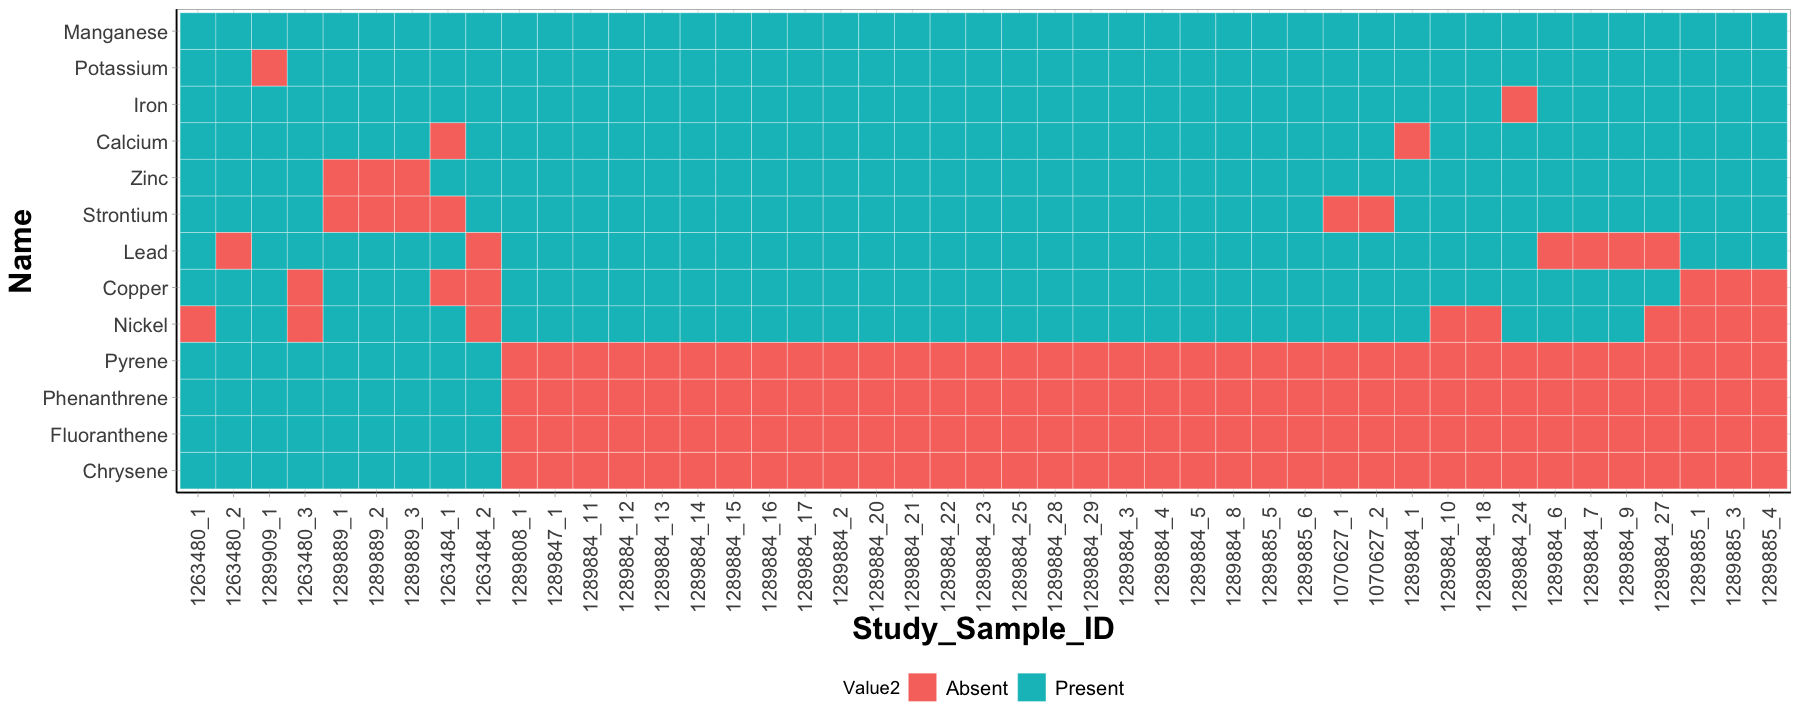

In [38]:
options(repr.plot.width=15, repr.plot.height=6) #changing size
ggplot(data = final_preimputed_vol_df, aes(x = Study_Sample_ID, y = Name, fill = Value2)) + 
  geom_tile(color = "white") + 

  theme_light() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = "bottom", #removing legend
        legend.text = element_text(size = 12)) #changes legend text 

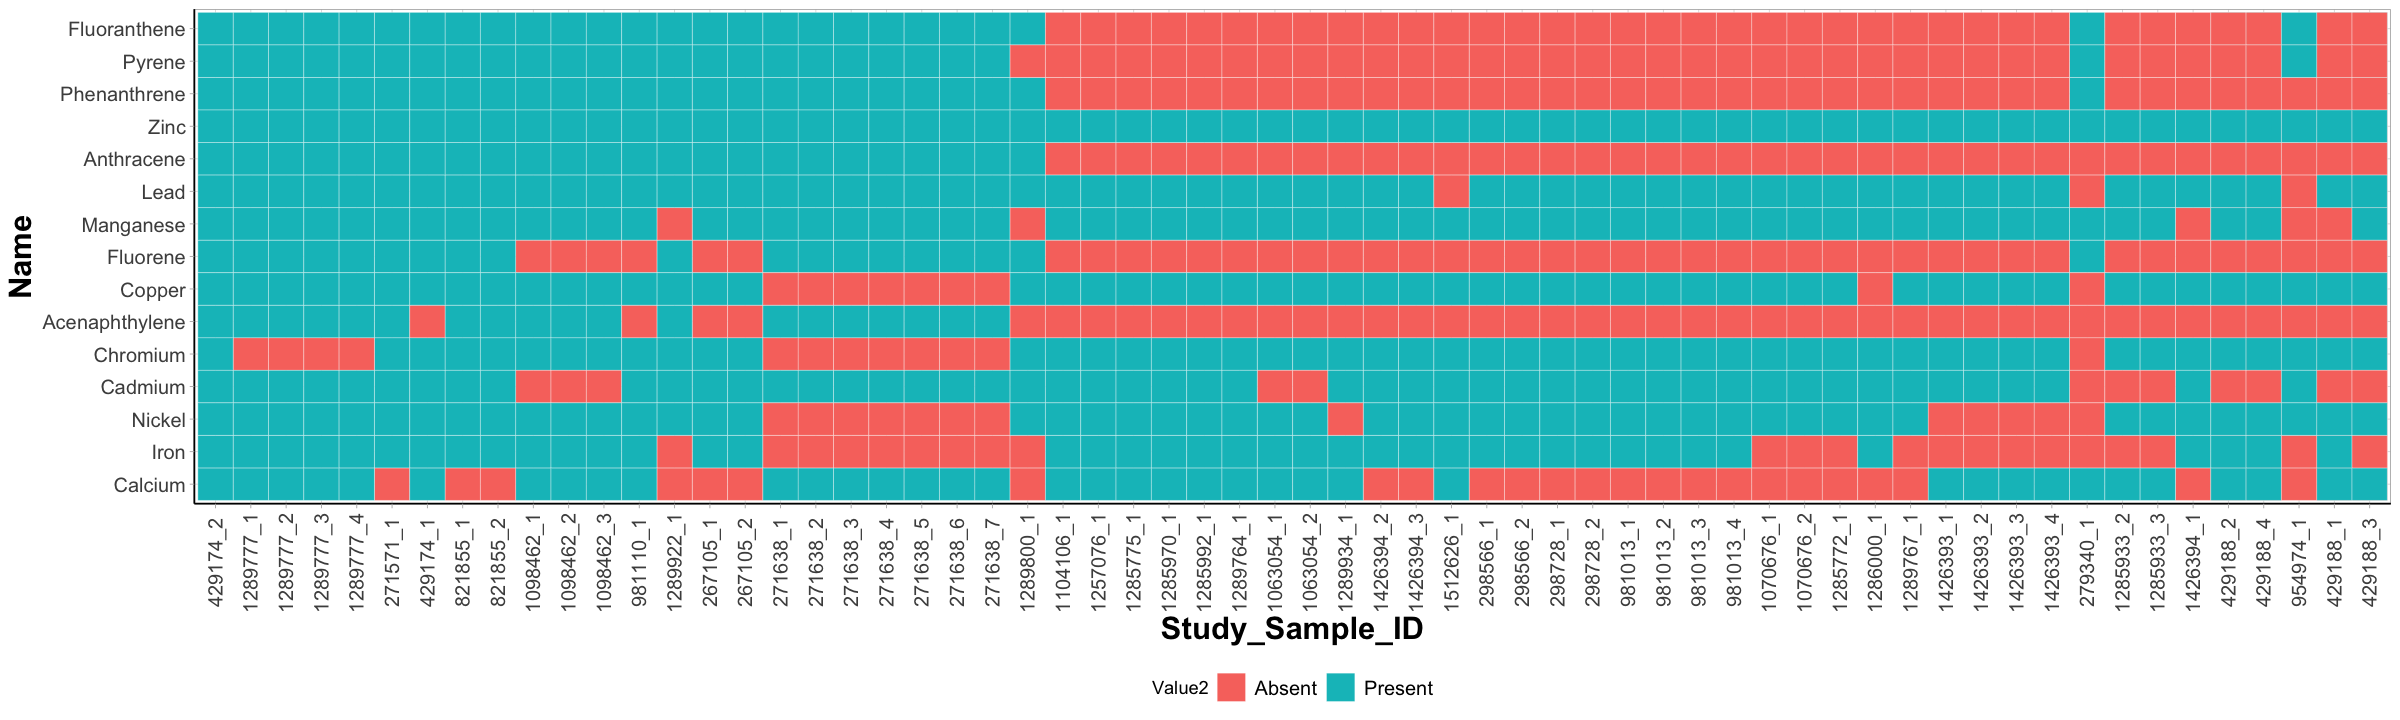

In [47]:
options(repr.plot.width=20, repr.plot.height=6) #changing size
ggplot(data = final_preimputed_weight_df, aes(x = Study_Sample_ID, y = Name, fill = Value2)) + 
  geom_tile(color = "white") + 

  theme_light() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = "bottom", #removing legend
        legend.text = element_text(size = 12)) #changes legend text 

Finding the percentage of missing data.

In [48]:
final_preimputed_vol_df %>%
    mutate(count = ifelse(Value2 == 'Absent', 1, 0)) %>%
    reframe(round((sum(count)/n()) * 100)) 

final_preimputed_weight_df %>%
    mutate(count = ifelse(Value2 == 'Absent', 1, 0)) %>%
    reframe(round((sum(count)/n()) * 100))

round((sum(count)/n()) * 100)
<dbl>
30


round((sum(count)/n()) * 100)
<dbl>
37


# RF Imputation

In [47]:
random_forest_imputation = function(dataset){
    # """
    # Using random forest (RF) to generate MAR data.

    # :param: preimputed dataframe
    # :output: a longer dataframe 

    # """

    # converting df to a wide format
    wide_df = dataset %>%
        select(-c("Name", "Class")) %>%
        pivot_wider(names_from = "DTXSID", values_from = "Value")
    
    preimputed_df = wide_df[,7:ncol(wide_df)]
    
    # setting seed for reproducibility
    set.seed(38)
    
    imputed_RF_object = missForest(as.matrix(preimputed_df))
    imputed_RF_df = imputed_RF_object$ximp
    # getting oob error to assess imputation error
    imputation_error = imputed_RF_object$OOBerror
    imputed_final_df = data.frame(cbind(wide_df[,1:6], imputed_RF_df)) %>%
        pivot_longer(cols = 7:ncol(wide_df), names_to = "DTXSID", values_to = "Value")
    
    return(list(imputed_final_df, imputation_error))
}

# calling fn
rf_vol_imputed_df = random_forest_imputation(preimputed_vol_df) 
rf_weight_imputed_df = random_forest_imputation(preimputed_weight_df)

rf_imputed_df = rbind(rf_vol_imputed_df[[1]], 
                      rf_weight_imputed_df[[1]]) 

head(rf_imputed_df)
dim(rf_imputed_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Study_Sample_ID,DTXSID,Value
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ca,8.59618976
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Ni,0.54649640
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID0022432,0.07997538
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,Sr,1.83875253
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID3024104,0.15574923
1289889,Volume,WF,Scaramboni et al. 2024,3,1289889_3,DTXSID6024254,0.07724300


[1] 2424    8

In [48]:
# OOB error
# WHICH TELLS US WHAT??!!
rf_vol_imputed_df[[2]]
rf_weight_imputed_df[[2]]

NRMSE 
0.1949368

NRMSE 
0.3407894

In [53]:
# adding back in name col
final_df = left_join(rf_imputed_df, 
                      combined_df[,c(6,8,9)] %>%
    unique()) 

final_df = final_df[,c(4,2,5,6,9,3,7,10,8)]

head(final_df)
dim(final_df)

Joining with `by = join_by(DTXSID)`


Study,Metric,Sample_Number,Study_Sample_ID,Class,Sample,DTXSID,Name,Value
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Scaramboni et al. 2024,Volume,3,1289889_3,Metal,WF,Ca,Calcium,8.59618976
Scaramboni et al. 2024,Volume,3,1289889_3,Metal,WF,Ni,Nickel,0.54649640
Scaramboni et al. 2024,Volume,3,1289889_3,PAH,WF,DTXSID0022432,Chrysene,0.07997538
Scaramboni et al. 2024,Volume,3,1289889_3,Metal,WF,Sr,Strontium,1.83875253
Scaramboni et al. 2024,Volume,3,1289889_3,PAH,WF,DTXSID3024104,Fluoranthene,0.15574923
Scaramboni et al. 2024,Volume,3,1289889_3,PAH,WF,DTXSID6024254,Phenanthrene,0.07724300


[1] 2424    9

In [ ]:
# exporting
write.xlsx(final_df, paste0(Output,"/", "Processed_Data_RF_Imputation", cur_date, ".xlsx"), 
           rowNames = FALSE)